In [2]:
# imporing required libraries
import librosa, librosa.display
import matplotlib.pyplot as plt
import soundfile
import os, glob
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.svm import SVC

In [3]:
#extracting features (mfcc, chroma, mel) from a sound file
def extract_feature(file_name, mfcc, chroma, mel):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
            
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result=np.hstack((result, mfccs))
        if chroma:
            stft=np.abs(librosa.stft(X))
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result=np.hstack((result, mel))
    return result

In [4]:
#emotions present in the RAVDESS dataset
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

#emotions to observe
observed_emotions=['calm', 'happy', 'fearful', 'angry', 'disgust', 'surprised']

In [5]:
#loading data with observed_emotions and extracting features for each sound file
def load_data():
    x,y=[],[]
    for file in glob.glob("./data/Actor_*/*.wav"):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append(emotion)
    return np.array(x), y

In [6]:
x,y=load_data()
x_train,x_test,y_train,y_test=train_test_split(x, y, test_size=0.2, random_state=9)

In [7]:
print((x_train.shape[0], x_test.shape[0]))
print(f'Features extracted: {x_train.shape[1]}')

(921, 231)
Features extracted: 180


In [44]:
# building model
model=SVC(kernel="linear", C=2)

In [45]:
# training model
model.fit(x_train,y_train)

SVC(C=2, kernel='linear')

In [46]:
# predicting for test data
y_pred=model.predict(x_test)

In [47]:
print("F1", round(f1_score(y_test, y_pred, average='macro'),2))
print("Precision", round(precision_score(y_test, y_pred, average='macro'),2))
print("Recall", round(recall_score(y_test, y_pred, average='macro'),2))

F1 0.57
Precision 0.57
Recall 0.57


In [48]:
# evaluating accuracy
scores = cross_val_score(model, x, y, cv=5)

In [49]:
print("Accuracy: %0.2f (+/- %0.2f)"%(scores.mean(), scores.std()*2))

Accuracy: 0.42 (+/- 0.07)


array([[28,  1,  4,  5,  4,  3],
       [ 0, 30,  4,  2,  1,  1],
       [ 2, 10, 22,  2,  3,  3],
       [ 3,  0,  8, 22,  6,  4],
       [ 3,  1,  2,  6, 17,  4],
       [ 2,  3,  7,  1,  3, 14]])

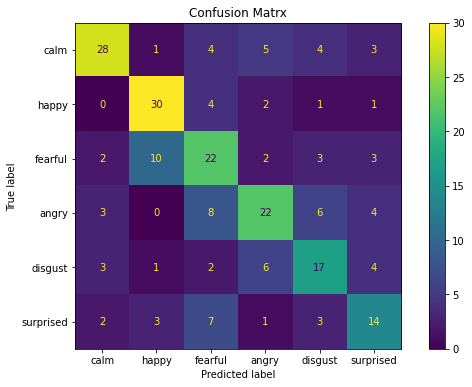

In [50]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Confusion Matrx')

disp =metrics.plot_confusion_matrix(model, x_test, y_test, display_labels= observed_emotions, ax = ax)
disp.confusion_matrix